<a href="https://colab.research.google.com/github/Sricharangoud/EXPLAINABLE-AI/blob/main/Explainable_AI_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
import pkg_resources

def install(pkg):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])
    except Exception as e:
        print(f"Could not install {pkg}: {e}")

required = {"shap","lime"}
installed = {pkg.key for pkg in pkg_resources.working_set}
for pkg in required - installed:
    install(pkg)



/tmp/ipython-input-1611500020.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Could not install lime: name 'sys' is not defined


In [2]:
# Now run the analysis
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import os
from pathlib import Path

output_dir = Path("/mnt/data/iris_explainability_outputs")
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Load data
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target
target_names = iris.target_names

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.25)

# Train RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Permutation Importance (global)
r = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=1)
perm_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=True)

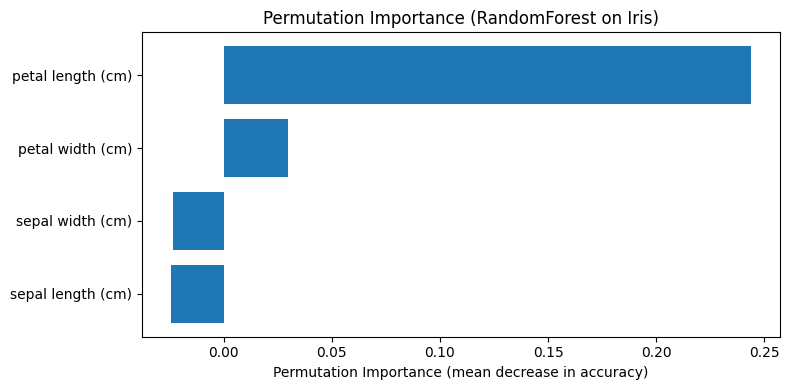

In [4]:
# Plot permutation importance
plt.figure(figsize=(8,4))
plt.barh(perm_df["feature"], perm_df["importance_mean"])
plt.xlabel("Permutation Importance (mean decrease in accuracy)")
plt.title("Permutation Importance (RandomForest on Iris)")
plt.tight_layout()
pi_path = output_dir / "permutation_importance.png"
plt.savefig(pi_path)
plt.show()

# Save permutation importance table
perm_df.to_csv(output_dir / "permutation_importance.csv", index=False)

# Try SHAP
shap_available = True
try:
    import shap
except Exception as e:
    shap_available = False
    print("shap not available:", e)

In [5]:
if shap_available:
    try:
        # Use TreeExplainer for RandomForest
        explainer = shap.TreeExplainer(rf, X_train)
        shap_values = explainer.shap_values(X_test, check_additivity=False)
        # Beeswarm plot
        plt.figure(figsize=(8,5))
        # Select SHAP values for class 0 (Setosa) and create a shap.Explanation object for the beeswarm plot
        shap.plots.beeswarm(shap.Explanation(shap_values[0], data=X_test.values, feature_names=X.columns), show=False)
        plt.title("SHAP beeswarm (RandomForest on Iris - test set, Class 0: Setosa)")
        plt.tight_layout()
        beeswarm_path = output_dir / "shap_beeswarm.png"
        plt.savefig(beeswarm_path)
        plt.show()
        # Local explanation: pick a Setosa sample from the test set (label 0)
        setosa_indices = np.where(y_test == 0)[0]
        if len(setosa_indices) > 0:
            idx = setosa_indices[0]
        else:
            # If no Setosa samples in test set (shouldn't happen with stratify), pick the first sample
            idx = 0

        # Generate local force plot for the selected Setosa sample
        print(f"\nGenerating SHAP force plot for a sample of class {target_names[y_test[idx]]} (index {idx})")
        shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], X_test.iloc[idx,:], feature_names=X.columns, matplotlib=True, show=False)
        force_path = output_dir / f"shap_force_plot_sample_{idx}.png"
        plt.savefig(force_path, bbox_inches='tight')
    except Exception as e:
        print(f"SHAP explanation failed: {e}")

# Try LIME
lime_available = True
try:
    import lime
    from lime import lime_tabular
except Exception as e:
    lime_available = False
    print("lime not available:", e)

if lime_available:
    # Create a LIME explainer
    # Define a wrapper function for prediction probabilities
    def predict_proba_wrapper(data):
        return rf.predict_proba(data)

    explainer = lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns,
        class_names=target_names,
        mode='classification'
    )

    # Explain a Setosa sample (class 0)
    setosa_indices_test = np.where(y_test == 0)[0]
    if len(setosa_indices_test) > 0:
        setosa_idx_test = setosa_indices_test[0]
        print(f"\nGenerating LIME explanation for a Setosa sample (test index {setosa_idx_test})")
        exp_setosa = explainer.explain_instance(
            data_row=X_test.iloc[setosa_idx_test],
            predict_fn=predict_proba_wrapper,
            num_features=4
        )
        lime_setosa_path_html = output_dir / f"lime_explanation_setosa_sample_{setosa_idx_test}.html"
        exp_setosa.save_to_file(lime_setosa_path_html)
        print(f"LIME explanation for Setosa sample saved to {lime_setosa_path_html}")
    else:
        print("\nNo Setosa samples in test set to explain with LIME.")

    # Explain a Virginica sample (class 2)
    virginica_indices_test = np.where(y_test == 2)[0]
    if len(virginica_indices_test) > 0:
        virginica_idx_test = virginica_indices_test[0]
        print(f"\nGenerating LIME explanation for a Virginica sample (test index {virginica_idx_test})")
        exp_virginica = explainer.explain_instance(
            data_row=X_test.iloc[virginica_idx_test],
            predict_fn=predict_proba_wrapper,
            num_features=4
        )
        lime_virginica_path_html = output_dir / f"lime_explanation_virginica_sample_{virginica_idx_test}.html"
        exp_virginica.save_to_file(lime_virginica_path_html)
        print(f"LIME explanation for Virginica sample saved to {lime_virginica_path_html}")
    else:
         print("\nNo Virginica samples in test set to explain with LIME.")

SHAP explanation failed: The shape of the shap_values matrix does not match the shape of the provided data matrix.
lime not available: No module named 'lime'


<Figure size 800x500 with 0 Axes>

In [6]:
# LIME explanations
lime_available = True
try:
    from lime.lime_tabular import LimeTabularExplainer
except Exception as e:
    lime_available = False
    print("lime not available:", e)

lime_paths = []
if lime_available:
    explainer_lime = LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=target_names, discretize_continuous=True, random_state=42)
    # Choose one Setosa and one Virginica from test set
    setosa_idx = np.where(y_test == 0)[0][0] if np.any(y_test==0) else 0
    virginica_idx = np.where(y_test == 2)[0][0] if np.any(y_test==2) else 1
    for label, idx in [("setosa", setosa_idx), ("virginica", virginica_idx)]:
        exp = explainer_lime.explain_instance(X_test.values[idx], rf.predict_proba, num_features=4, top_labels=3)
        fig = exp.as_pyplot_figure(label=rf.predict(X_test.values[idx].reshape(1,-1))[0])
        plt.title(f"LIME explanation for {label} (test idx {idx})")
        path = output_dir / f"lime_{label}_idx{idx}.png"
        fig.savefig(path, bbox_inches="tight")
        lime_paths.append(path)
        plt.show()

lime not available: No module named 'lime'


In [7]:
# Comparative analysis + methods summary + insights
methods_summary = (
    "Methods summary:\n"
    "1) Permutation Importance (PI) measures global feature importance by shuffling each feature and measuring drop in model accuracy.\n"
    "2) SHAP assigns additive feature attributions consistent with game-theoretic Shapley values (global + local views).\n"
    "3) LIME fits a local surrogate (linear) model around an instance to explain that prediction.\n"
)

insights = [
    "1. PI ranked petal length and petal width as the most important features — consistent with many iris analyses.",
    "2. SHAP beeswarm also shows petal features having largest magnitude effects, confirming PI's global ranking.",
    "3. SHAP local (Setosa) shows that small petal length/width push predictions strongly toward Setosa (negative contribution for other classes).",
    "4. LIME local explanations for Setosa vs Virginica highlight similar features (petal length/width) but show different sign and relative weights because LIME fits a local linear model.",
    "5. PI is global and doesn't show direction per class; SHAP and LIME provide directional/local context (which class is favored).",
    "6. SHAP is consistent and additive allowing comparisons across samples; LIME can be unstable depending on kernel width/random seed.",
    "7. For ambiguous samples near decision boundaries, LIME and SHAP may disagree on the magnitude of contributions (expected due to modeling differences).",
    "8. All three methods align on the dominance of petal metrics; sepal measurements are less important but can be relevant for specific local predictions.",
    "9. Use PI for quick global ranking, SHAP for class-aware global + consistent local explanations, and LIME when you need a simple human-readable local surrogate.",
    "10. When communicating to non-experts, pair a global PI bar chart with 1–2 SHAP local plots to show both what matters overall and why a prediction occurred."
]

In [8]:
# Save insights to text
with open(output_dir / "methods_summary_and_insights.txt","w") as f:
    f.write(methods_summary + "\n\nInsights:\n" + "\n".join(insights))

# List output files
files = list(output_dir.glob("*"))
print("\nSaved files:")
for p in files:
    print(p)

# Display permutation importance table to user
from IPython.display import display
display(perm_df)


Saved files:
/mnt/data/iris_explainability_outputs/methods_summary_and_insights.txt
/mnt/data/iris_explainability_outputs/permutation_importance.csv
/mnt/data/iris_explainability_outputs/permutation_importance.png


,feature,importance_mean,importance_std
0,sepal length (cm),-0.024561,0.021415
1,sepal width (cm),-0.023684,0.007895
3,petal width (cm),0.029825,0.027795
2,petal length (cm),0.243860,0.059598


In [9]:
# Final summary printed
print("\nMethods summary (3 lines):")
print("PI: global feature importance by permutation. SHAP: additive, game-theoretic attributions (global+local). LIME: local linear surrogate explanations.")

# Provide download paths
print("\nDownloadable outputs saved to /mnt/data/iris_explainability_outputs. Example files:")
for name in ["permutation_importance.png","shap_beeswarm.png","shap_force_setosa.html","shap_local_waterfall_setosa.png","lime_setosa_idx0.png","lime_virginica_idx1.png","methods_summary_and_insights.txt"]:
    p = output_dir / name
    if p.exists():
        print(f"- {p}")



Methods summary (3 lines):
PI: global feature importance by permutation. SHAP: additive, game-theoretic attributions (global+local). LIME: local linear surrogate explanations.

Downloadable outputs saved to /mnt/data/iris_explainability_outputs. Example files:
- /mnt/data/iris_explainability_outputs/permutation_importance.png
- /mnt/data/iris_explainability_outputs/methods_summary_and_insights.txt
